In [105]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta, timezone

In [106]:
# =============================================================================
# 1. Data Fetching: Retrieve ETH/USD hourly prices for the past year from CoinGecko
# =============================================================================
COINGECKO_API_URL = "https://api.coingecko.com/api/v3/coins/ethereum/market_chart/range"
historical_data = []
DAYS_PER_REQUEST = 90  # Maximum chunk size for hourly data

# Define the time range: last 365 days from now
end_date = datetime.now(tz=timezone.utc)
start_date = end_date - timedelta(days=365)
start_timestamp = int(start_date.timestamp())
end_timestamp = int(end_date.timestamp())
current_start = start_timestamp

print("Fetching historical ETH/USD hourly prices from CoinGecko...")
while current_start < end_timestamp:
    current_end = min(current_start + (DAYS_PER_REQUEST * 24 * 60 * 60), end_timestamp)
    params = {
        "vs_currency": "usd",
        "from": current_start,
        "to": current_end
    }
    print(f"Fetching data from {datetime.utcfromtimestamp(current_start).strftime('%Y-%m-%d')} "
          f"to {datetime.utcfromtimestamp(current_end).strftime('%Y-%m-%d')}...")
    response = requests.get(COINGECKO_API_URL, params=params)
    if response.status_code == 200:
        data = response.json().get("prices", [])
        for entry in data:
            timestamp = datetime.utcfromtimestamp(entry[0] / 1000).strftime('%Y-%m-%d %H:%M:%S')
            price = entry[1]
            historical_data.append([timestamp, price])
    else:
        print(f"Error fetching data: {response.status_code} - {response.text}")
        break
    current_start = current_end

# Convert to DataFrame
df = pd.DataFrame(historical_data, columns=["Date", "Price"])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# For simulation purposes, filter the data to start on January 1, 2024 (if available)
start_simulation = pd.Timestamp("2024-01-01")
df = df[df.index >= start_simulation]

# Optionally, save the data:
df.to_csv("eth_usdc_hourly_prices_1year.csv", index=True)
print("Data saved successfully as 'eth_usdc_hourly_prices_1year.csv'")

Fetching historical ETH/USD hourly prices from CoinGecko...
Fetching data from 2024-02-14 to 2024-05-14...
Fetching data from 2024-05-14 to 2024-08-12...
Fetching data from 2024-08-12 to 2024-11-10...
Fetching data from 2024-11-10 to 2025-02-08...
Fetching data from 2025-02-08 to 2025-02-13...
Data saved successfully as 'eth_usdc_hourly_prices_1year.csv'


In [130]:
# =============================================================================
# 2. Helper Functions for Uniswap v3 LP Simulation (No Fee Accrual)
# =============================================================================

def calculate_range(price, x):
    """
    Calculates the active LP range based on the current price and x.
    Returns (lower_bound, upper_bound).
    """
    lower_bound = price / (1 + x)
    upper_bound = price * (1 + x)
    return lower_bound, upper_bound

def rebalance_position(eth_balance, usdc_balance, current_price):
    """
    Rebalances the portfolio to maintain a 50/50 exposure (by value) in ETH and USDC.
    """
    total_value = eth_balance * current_price + usdc_balance
    eth_target = total_value / (2 * current_price)
    usdc_target = total_value / 2
    return eth_target, usdc_target

def compute_liquidity(deposit_eth, deposit_price, x):
    """
    Given a deposit of deposit_eth (in ETH) and its equivalent USDC value,
    computes the liquidity L and the active price range:
       [deposit_price/(1+x), deposit_price*(1+x)].
    """
    deposit_usdc = deposit_eth * deposit_price
    lower = deposit_price / (1 + x)
    upper = deposit_price * (1 + x)
    S = np.sqrt(deposit_price)
    Sa = np.sqrt(lower)
    # Liquidity L formula for Uniswap v3 concentrated liquidity:
    L = deposit_usdc / (S - Sa)
    return L, lower, upper

def compute_lp_value(L, current_price, lower, upper):
    """
    Computes the LP position value (in USDC) and token amounts given liquidity L,
    current_price, and the active range [lower, upper].
    """
    S = np.sqrt(current_price)
    Sa = np.sqrt(lower)
    Sb = np.sqrt(upper)
    if current_price <= lower:
        amt_eth = L * (Sb - Sa) / (Sb * Sa)
        value = amt_eth * current_price
        return value, amt_eth, 0.0
    elif current_price >= upper:
        amt_usdc = L * (Sb - Sa)
        value = amt_usdc
        return value, 0.0, amt_usdc
    else:
        amt_eth = L * (Sb - S) / (S * Sb)
        amt_usdc = L * (S - Sa)
        value = amt_eth * current_price + amt_usdc
        return value, amt_eth, amt_usdc

In [131]:
def simulate_lp_strategy(df, x, initial_eth=100):
    """
    Simulate the Uniswap v3 LP strategy without fee accrual:
      - On day 1, convert half of initial ETH to USDC (for a 50/50 allocation).
      - Open an LP position in the range [P/(1+x), P*(1+x)].
      - When price exits the range, record an impermanent loss event, rebalance
        to 50/50, and open a new LP position centered at the current price.

    Returns:
      simulation_df: DataFrame with a 'LP_Portfolio' column tracking portfolio value and
                     a 'Rebalance' flag indicating a rebalancing event.
      il_events: List of impermanent loss events.
      rebalancing_dates: List of datetime objects when rebalancing occurred.
    """
    # Initial rebalancing for 50/50 allocation:
    deposit_eth = initial_eth / 2.0
    deposit_price = df.iloc[0]['Price']
    deposit_usdc = deposit_eth * deposit_price

    # Open initial LP position using Uniswap v3 math:
    L, lower, upper = compute_liquidity(deposit_eth, deposit_price, x)
    current_L = L
    current_lower = lower
    current_upper = upper
    current_eth = deposit_eth
    current_usdc = deposit_usdc

    # Lists to store simulation data:
    timestamps = []
    portfolio_values = []
    il_events = []
    rebalancing_dates = []
    rebalance_flags = []  # Will mark True if rebalancing occurred at that timestamp

    for idx, row in df.iterrows():
        current_date = idx
        price = row['Price']
        rebalance_flag = False  # Default flag

        # If price is within the current LP range, compute LP value.
        if current_lower <= price <= current_upper:
            lp_value, amt_eth, amt_usdc = compute_lp_value(current_L, price, current_lower, current_upper)
            portfolio_values.append(lp_value)
        else:
            # Price has exited the active range: record impermanent loss and rebalance.
            lp_value, amt_eth, amt_usdc = compute_lp_value(current_L, price, current_lower, current_upper)
            hodl_value = current_eth * price + current_usdc
            il = hodl_value - lp_value  # Impermanent loss relative to HODL value.
            il_events.append({'Time': current_date, 'Price': price, 'IL': il})
            rebalancing_dates.append(current_date)
            rebalance_flag = True  # Mark this timestamp as a rebalance event
            # Rebalance to 50/50 at current price:
            current_eth, current_usdc = rebalance_position(current_eth, current_usdc, price)
            L, lower, upper = compute_liquidity(current_eth, price, x)
            current_L = L
            current_lower = lower
            current_upper = upper
            portfolio_values.append(lp_value)
        timestamps.append(current_date)
        rebalance_flags.append(rebalance_flag)

    simulation_df = pd.DataFrame({
        'LP_Portfolio': portfolio_values,
        'Rebalance': rebalance_flags
    }, index=timestamps)

    return simulation_df, il_events, rebalancing_dates


In [132]:
def compute_performance_metrics(df, column='LP_Portfolio'):
    """
    Computes performance metrics for the provided portfolio value column.
    Returns: avg_daily_return, std_daily_return, sharpe_ratio, max_drawdown.
    """
    df = df.copy()
    df['Return'] = df[column].pct_change().fillna(0)
    avg_daily_return = df['Return'].mean()
    std_daily_return = df['Return'].std()
    sharpe_ratio = (avg_daily_return / std_daily_return * np.sqrt(252)) if std_daily_return != 0 else np.nan
    df['Cumulative'] = df[column]
    df['Cumulative_max'] = df['Cumulative'].cummax()
    df['Drawdown'] = df[column] / df['Cumulative_max'] - 1
    max_drawdown = df['Drawdown'].min()
    return avg_daily_return, std_daily_return, sharpe_ratio, max_drawdown


In [133]:
def simulate_hodl_strategy(df, initial_eth=100):
    """
    Simulate a simple buy-and-hold strategy with a 50/50 allocation on day 1.
    Returns a DataFrame with a 'HODL_Portfolio' column.
    """
    deposit_eth = initial_eth / 2.0
    deposit_price = df.iloc[0]['Price']
    deposit_usdc = deposit_eth * deposit_price
    portfolio_values = []
    for idx, row in df.iterrows():
        price = row['Price']
        value = deposit_eth * price + deposit_usdc
        portfolio_values.append(value)
    hodl_df = df.copy()
    hodl_df['HODL_Portfolio'] = portfolio_values
    return hodl_df

In [134]:
# =============================================================================
# 3. Compare with HODL Strategy
# =============================================================================
hodl_df = simulate_hodl_strategy(df, initial_eth=100)
hodl_df['Daily_Return'] = hodl_df['HODL_Portfolio'].pct_change().fillna(0)
hodl_df['Cumulative_Return'] = (1 + hodl_df['Daily_Return']).cumprod() - 1
hodl_avg, hodl_std, hodl_sharpe, hodl_mdd = compute_performance_metrics(hodl_df, column='HODL_Portfolio')
print(f"\nHODL Strategy => Final portfolio value: {hodl_df.iloc[-1]['HODL_Portfolio']:.2f} USDC, Total Return: {hodl_df.iloc[-1]['Cumulative_Return']*100:.2f}%, "
      f"Sharpe Ratio: {hodl_sharpe:.2f}, Max Drawdown: {hodl_mdd*100:.2f}%")


HODL Strategy => Final portfolio value: 269715.35 USDC, Total Return: -1.77%, Sharpe Ratio: 0.02, Max Drawdown: -27.55%


In [135]:
# =============================================================================
# 4. Optimal x Value Analysis Across Different Scenarios
# =============================================================================
# Simulate over a set of x values and compute performance metrics.
x_values = [0.05, 0.10, 0.15, 0.20]
summary_data = []
for x in x_values:
    sim_df_x, il_events_x, _ = simulate_lp_strategy(df, x, initial_eth=100)
    final_value = sim_df_x.iloc[-1]['LP_Portfolio']
    initial_value = sim_df_x.iloc[0]['LP_Portfolio']
    total_return = (final_value / initial_value - 1) * 100  # in %
    # Compute average impermanent loss (if events occurred)
    if il_events_x:
        avg_il = sum(event['IL'] for event in il_events_x) / len(il_events_x)
    else:
        avg_il = np.nan
    avg_daily, std_daily, sharpe, max_dd = compute_performance_metrics(sim_df_x, column='LP_Portfolio')
    summary_data.append({
        'x': x,
        'Final Portfolio Value (USDC)': final_value,
        'Total Return (%)': total_return,
        'Average Impermanent Loss': avg_il,
        'Sharpe Ratio': sharpe,
        'Max Drawdown (%)': max_dd * 100,
        'Total Impermanent Loss points': len(il_events_x)
    })

summary_df = pd.DataFrame(summary_data)
print("Summary Metrics for Different x Values:")
summary_df

Summary Metrics for Different x Values:


,x,Final Portfolio Value (USDC),Total Return (%),Average Impermanent Loss,Sharpe Ratio,Max Drawdown (%),Total Impermanent Loss points
0,0.05,285833.762723,4.101590,4920.547497,0.053708,-25.863979,144
1,0.10,288583.525592,5.103063,8951.243148,0.057164,-25.980745,48
2,0.15,285456.522772,3.964198,11989.443786,0.051952,-25.647080,22
3,0.20,287564.378239,4.731886,16160.225342,0.055161,-28.311943,14


In [136]:
points_df = summary_df[['x', 'Total Impermanent Loss points']]
points_df

,x,Total Impermanent Loss points
0,0.05,144
1,0.10,48
2,0.15,22
3,0.20,14


In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define x values from 0.1 to 0.20 using 50 points
x_grid = np.linspace(0.01, 0.20, 50)
grid_summary = []

for x in x_grid:
    # Run the simulation for the given x value
    sim_df_grid, il_events_grid, _ = simulate_lp_strategy(df, x, initial_eth=100)

    # Get the initial and final LP portfolio values
    final_value = sim_df_grid.iloc[-1]['LP_Portfolio']
    initial_value = sim_df_grid.iloc[0]['LP_Portfolio']
    total_return = (final_value / initial_value - 1) * 100  # Total return in %

    # Compute performance metrics: Sharpe ratio and maximum drawdown
    avg_daily, std_daily, sharpe, max_dd = compute_performance_metrics(sim_df_grid, column='LP_Portfolio')
    max_drawdown_pct = max_dd * 100  # Convert to percentage

    # Compute a Calmar-like ratio (total return divided by absolute max drawdown)
    if abs(max_drawdown_pct) > 0:
        calmar_ratio = total_return / abs(max_drawdown_pct)
    else:
        calmar_ratio = np.nan

    # Composite metric: Average of Sharpe ratio and Calmar ratio.
    composite = (sharpe + calmar_ratio) / 2

    grid_summary.append({
        'x': x,
        'Sharpe Ratio': sharpe,
        'Total Returns (%)': total_return,
        'Max Drawdown (%)': max_drawdown_pct,
        'Calmar Ratio': calmar_ratio,
        'Composite': composite
    })

grid_summary_df = pd.DataFrame(grid_summary)
# Determine the optimal x value using the highest composite metric
optimal_row = grid_summary_df.loc[grid_summary_df['Composite'].idxmax()]
optimal_x = optimal_row['x']
result = optimal_row[['x', 'Sharpe Ratio', 'Total Returns (%)', 'Max Drawdown (%)']]

print("\nOptimal x value (based on composite metric of Sharpe and Calmar Ratios):", optimal_x)
print("Optimal performance metrics:")
result



Optimal x value (based on composite metric of Sharpe and Calmar Ratios): 0.041020408163265305
Optimal performance metrics:


,8
x,0.041020
Sharpe Ratio,0.056016
Total Returns (%),4.757144
Max Drawdown (%),-26.098248


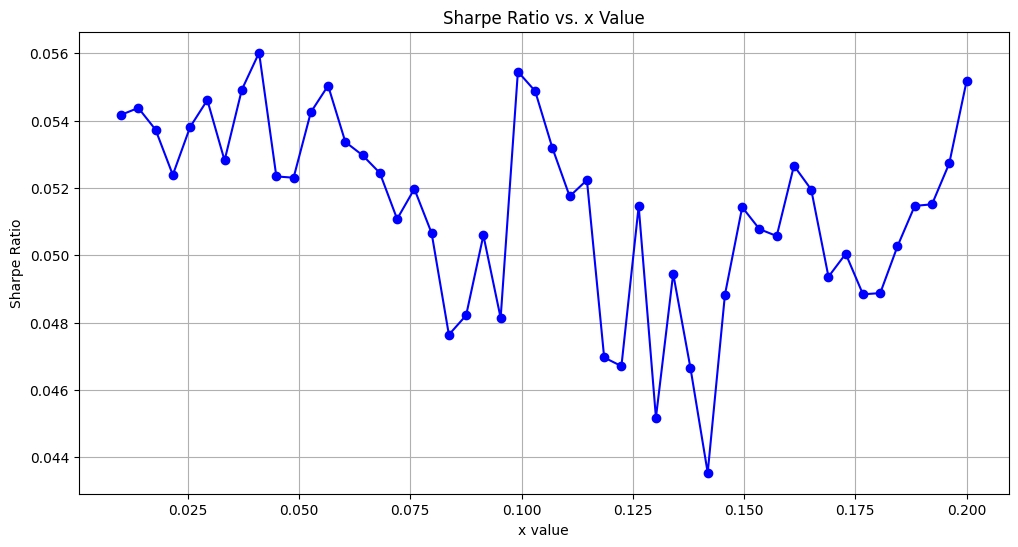

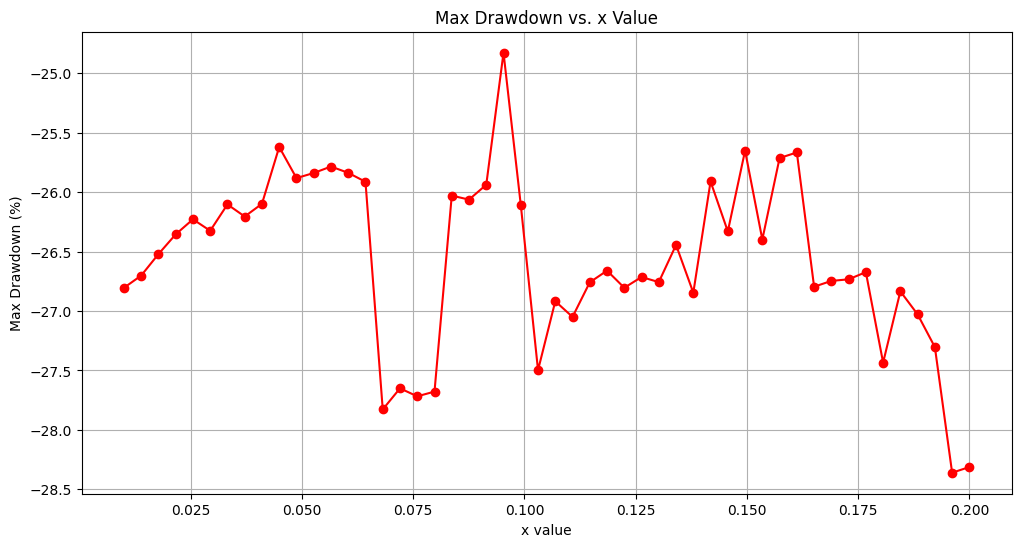

In [148]:
# Plot Sharpe Ratio vs. x
plt.figure(figsize=(12, 6))
plt.plot(grid_summary_df['x'], grid_summary_df['Sharpe Ratio'], marker='o', linestyle='-', color='blue')
plt.xlabel('x value')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio vs. x Value')
plt.grid(True)
plt.show()

# Plot Maximum Drawdown (%) vs. x
plt.figure(figsize=(12, 6))
plt.plot(grid_summary_df['x'], grid_summary_df['Max Drawdown (%)'], marker='o', linestyle='-', color='red')
plt.xlabel('x value')
plt.ylabel('Max Drawdown (%)')
plt.title('Max Drawdown vs. x Value')
plt.grid(True)
plt.show()


In [137]:
# Grid search over x using a composite metric (Sharpe and Calmar) as the optimality criterion:
x_grid = np.linspace(0.01, 0.20, 50)
grid_summary = []

for x in x_grid:
    # Run the simulation for the given x value
    sim_df_grid, il_events_grid, _ = simulate_lp_strategy(df, x, initial_eth=100)

    # Get the initial and final LP portfolio values
    final_value = sim_df_grid.iloc[-1]['LP_Portfolio']
    initial_value = sim_df_grid.iloc[0]['LP_Portfolio']
    total_return = (final_value / initial_value - 1) * 100  # Total return in %

    # Compute performance metrics: Sharpe ratio and maximum drawdown
    avg_daily, std_daily, sharpe, max_dd = compute_performance_metrics(sim_df_grid, column='LP_Portfolio')
    max_drawdown_pct = max_dd * 100  # Convert to percentage

    # Compute a Calmar-like ratio (total return divided by absolute max drawdown)
    # Avoid division by zero if max_drawdown is zero.
    if abs(max_drawdown_pct) > 0:
        calmar_ratio = total_return / abs(max_drawdown_pct)
    else:
        calmar_ratio = np.nan

    # Composite metric: Average of Sharpe ratio and Calmar ratio.
    # You could weight these differently if desired.
    composite = (sharpe + calmar_ratio) / 2

    grid_summary.append({
        'x': x,
        'Sharpe Ratio': sharpe,
        'Total Returns (%)': total_return,
        'Max Drawdown (%)': max_drawdown_pct,
        'Calmar Ratio': calmar_ratio,
        'Composite': composite
    })

grid_summary_df = pd.DataFrame(grid_summary)




Optimal x value (based on composite metric of Sharpe and Calmar Ratios): 0.041020408163265305
Optimal performance metrics:


,8
x,0.041020
Sharpe Ratio,0.056016
Total Returns (%),4.757144
Max Drawdown (%),-26.098248


In [138]:
# =============================================================================
# 5. Run Simulation for a Chosen x Value and Visualize
# =============================================================================
chosen_x = optimal_x  # For example, use x = 10%
simulation_df, il_events, rebalancing_dates = simulate_lp_strategy(df, chosen_x, initial_eth=100)

# Display a few rebalancing dates and impermanent loss events:
rebalance_df = pd.DataFrame({'Rebalance_Date': [d.date() for d in rebalancing_dates]})
# print("Sample Rebalancing Dates:")
# print(rebalance_df.head())

if il_events:
    il_events_df = pd.DataFrame(il_events)
else:
    il_events_df = pd.DataFrame(columns=['Time', 'Price', 'IL'])
print("\nSample Impermanent Loss Events for x =", chosen_x)
il_events_df


Sample Impermanent Loss Events for x = 0.041020408163265305


,Time,Price,IL
0,2024-02-18 23:01:12,2878.501934,3851.658122
1,2024-02-20 23:01:54,2999.411832,3051.193008
2,2024-02-26 16:03:14,3131.913506,3427.002685
3,2024-02-27 11:01:54,3261.656238,3099.212729
4,2024-02-28 17:01:15,3445.715191,5410.701639
...,...,...,...
193,2025-02-07 21:03:26,2590.322865,3283.934726
194,2025-02-11 01:08:51,2711.062352,3737.647769
195,2025-02-11 20:03:27,2589.766851,3684.840757
196,2025-02-12 23:04:23,2749.929281,5904.252863


In [139]:
# =============================================================================
# Compute Time-Based Returns for Uniswap v3 LP Strategy
# =============================================================================

def compute_time_based_returns(simulation_df):
    """
    Computes time-based returns for the LP strategy, including:
    - Daily Returns
    - Cumulative Returns
    - Weekly Returns
    - Monthly Returns

    Parameters:
    - simulation_df (pd.DataFrame): DataFrame containing 'LP_Portfolio' values over time.

    Returns:
    - simulation_df (pd.DataFrame): Updated DataFrame with daily and cumulative returns.
    - weekly_returns (pd.Series): Weekly percentage returns.
    - monthly_returns (pd.Series): Monthly percentage returns.
    """

    # Compute daily returns (percentage change from previous day)
    simulation_df['Daily_Return'] = simulation_df['LP_Portfolio'].pct_change().fillna(0)

    # Compute cumulative returns (compounded growth over time)
    simulation_df['Cumulative_Return'] = (1 + simulation_df['Daily_Return']).cumprod() - 1

    # Compute weekly returns (resampling the last value of each week)
    weekly_returns = simulation_df['LP_Portfolio'].resample('W').last().pct_change().fillna(0)

    # Compute monthly returns (resampling the last value of each month)
    # Compute Monthly Returns (Only for Complete Months)
    monthly_returns = simulation_df['LP_Portfolio'].resample('ME').last().pct_change().fillna(0)

    # Remove the last month if the dataset is still in an ongoing month
    latest_data_date = simulation_df.index.max()  # Get the last available date in the dataset
    latest_month_end = latest_data_date.replace(day=1) + pd.DateOffset(months=1) - pd.DateOffset(days=1)

    # Drop last entry if the month isn't fully completed
    if latest_data_date < latest_month_end:
      monthly_returns = monthly_returns.iloc[:-1]


    return simulation_df, weekly_returns, monthly_returns

# Apply the function to compute returns
simulation_df, weekly_returns, monthly_returns = compute_time_based_returns(simulation_df)

Latest Daily Returns (LP Strategy):


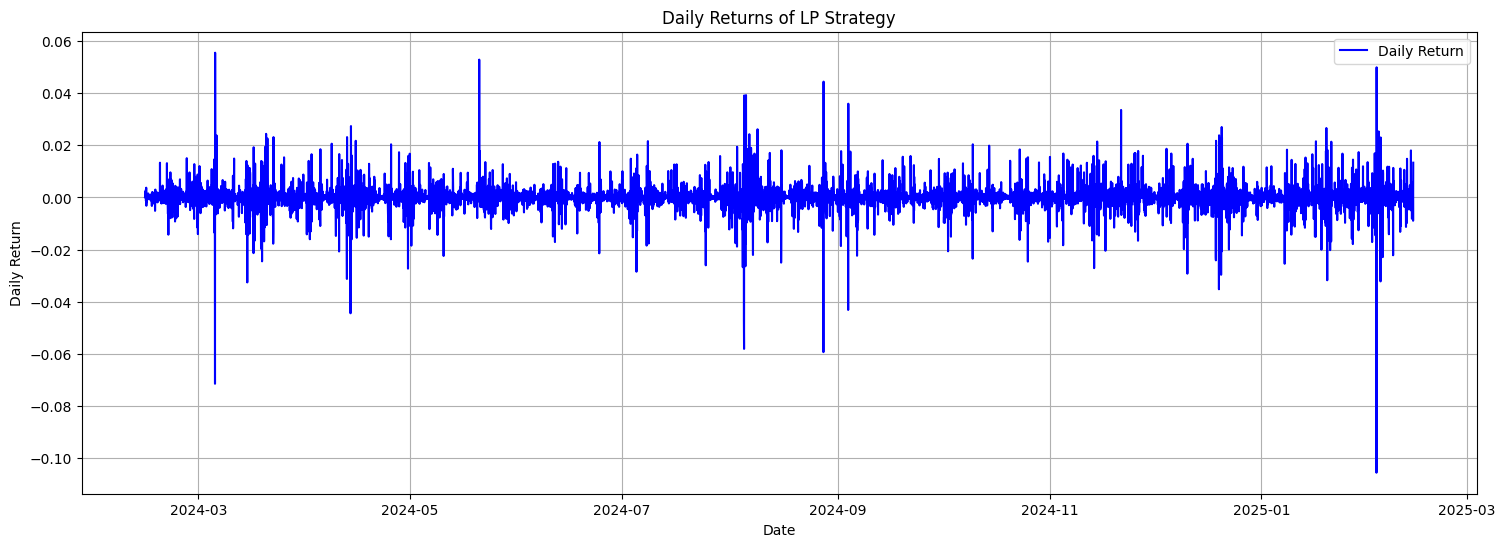

In [140]:
# =============================================================================
# Print Latest Returns for Validation
# =============================================================================
print("Latest Daily Returns (LP Strategy):")
simulation_df['Daily_Return']


import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
plt.plot(simulation_df.index, simulation_df['Daily_Return'], label='Daily Return', color='blue')
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.title("Daily Returns of LP Strategy")
plt.legend()
plt.grid(True)
plt.show()


Latest Weekly Returns (LP Strategy):


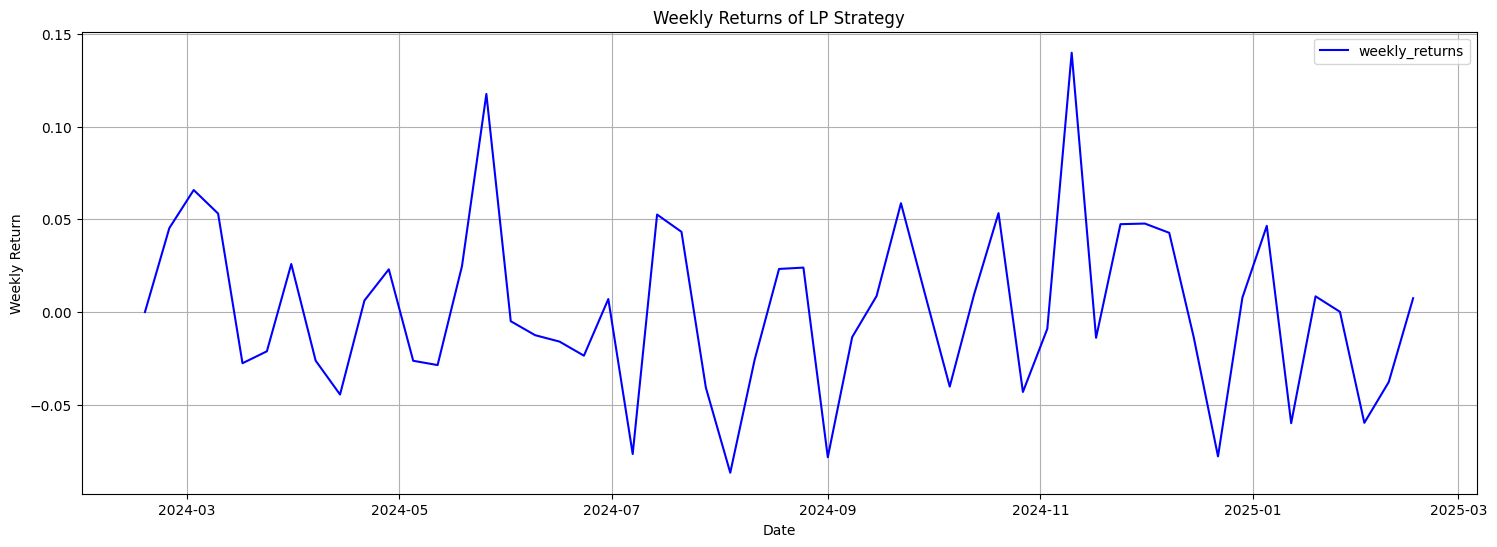

In [141]:
print("\nLatest Weekly Returns (LP Strategy):")
weekly_returns.tail()

plt.figure(figsize=(18, 6))
plt.plot(weekly_returns.index, weekly_returns.values, label='weekly_returns', color='blue')  # Corrected line
plt.xlabel("Date")
plt.ylabel("Weekly Return")
plt.title("Weekly Returns of LP Strategy")
plt.legend()
plt.grid(True)
plt.show()


Latest Monthly Returns (LP Strategy):


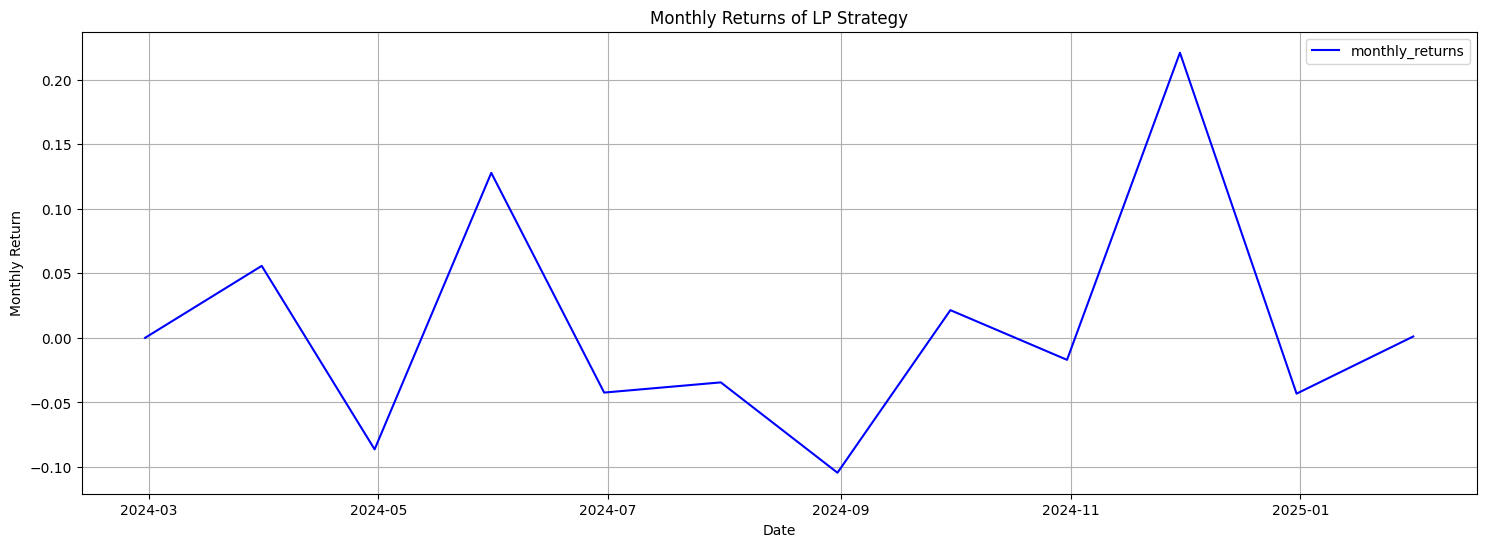

In [142]:
print("\nLatest Monthly Returns (LP Strategy):")
monthly_returns

plt.figure(figsize=(18, 6))
plt.plot(monthly_returns.index, monthly_returns.values, label='monthly_returns', color='blue')  # Corrected line
plt.xlabel("Date")
plt.ylabel("Monthly Return")
plt.title("Monthly Returns of LP Strategy")
plt.legend()
plt.grid(True)
plt.show()

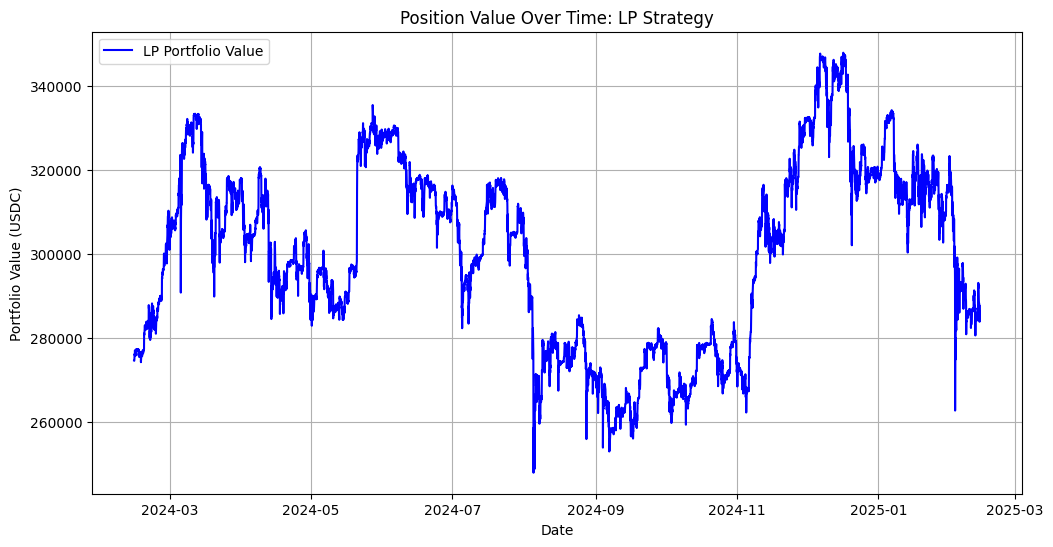

In [143]:
import matplotlib.pyplot as plt

# Plot the LP portfolio value over time from the simulation DataFrame
plt.figure(figsize=(12, 6))
plt.plot(simulation_df.index, simulation_df['LP_Portfolio'], label='LP Portfolio Value', color='blue')
plt.xlabel("Date")
plt.ylabel("Portfolio Value (USDC)")
plt.title("Position Value Over Time: LP Strategy")
plt.legend()
plt.grid(True)
plt.show()

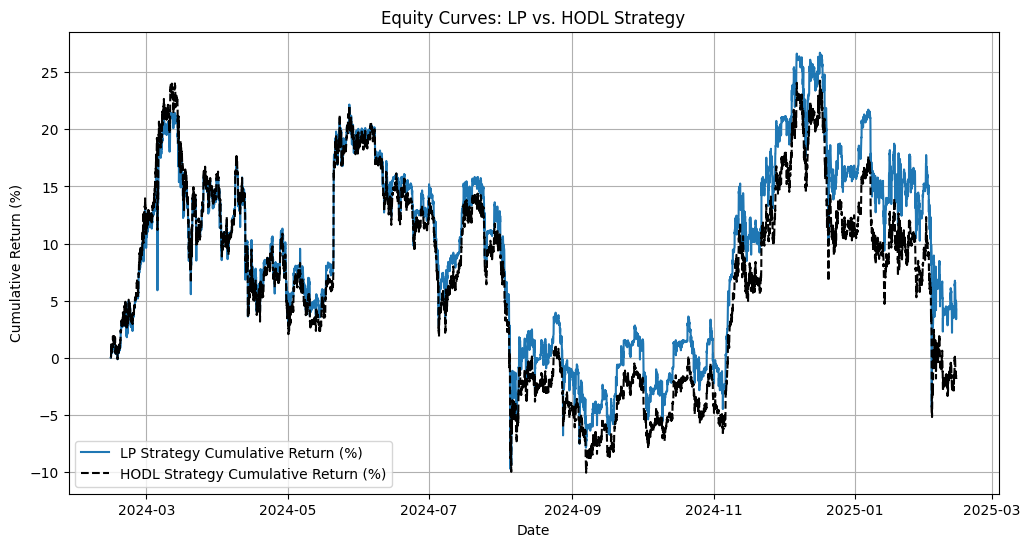

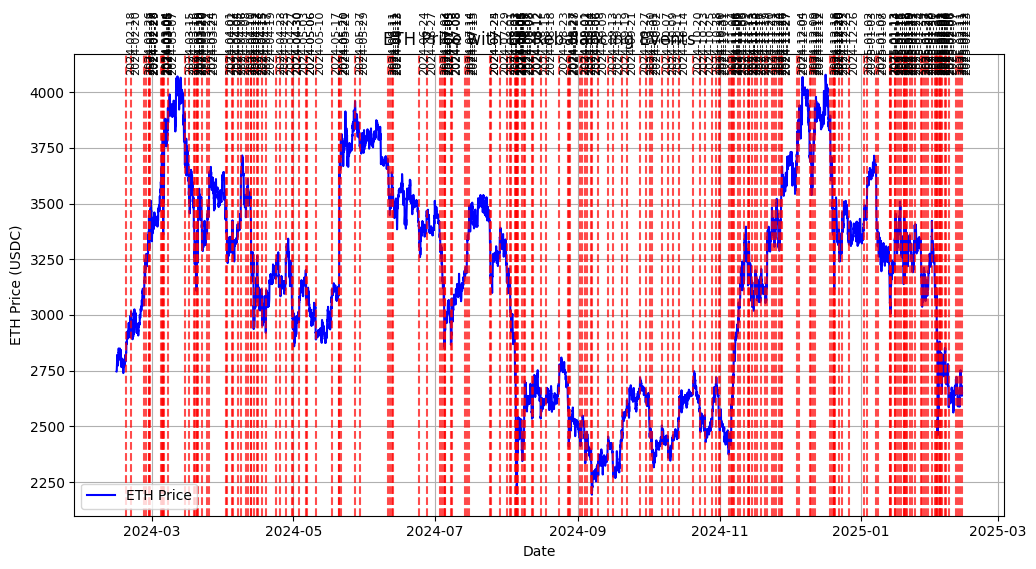

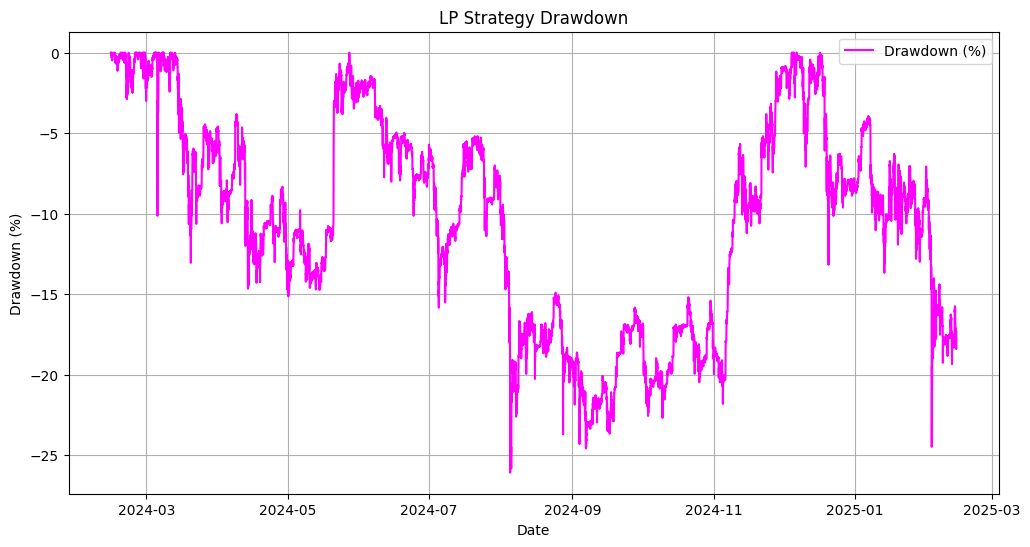

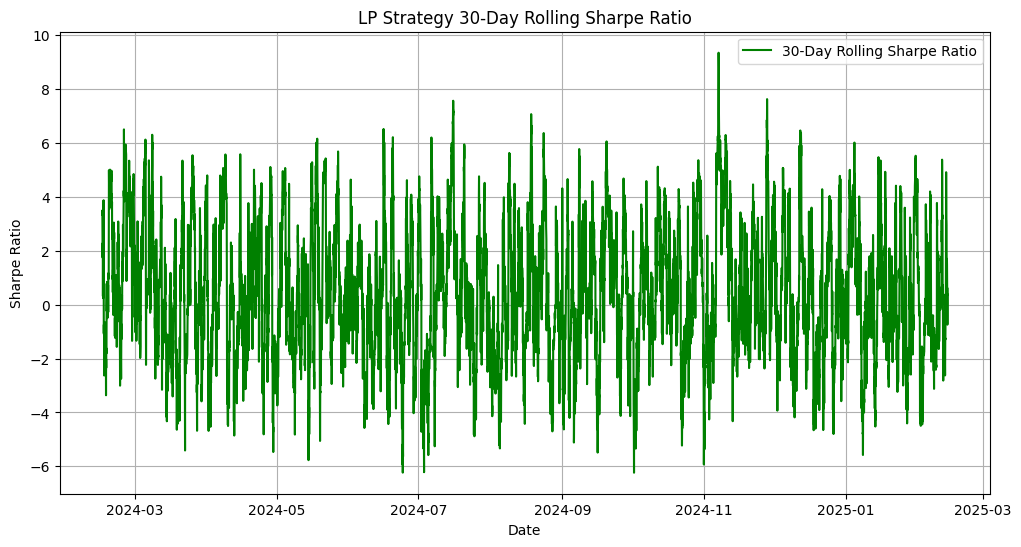

In [144]:
#=============================================================================
# 6. Visualizations
# =============================================================================

# 6a. Equity Curves: LP vs. HODL
plt.figure(figsize=(12, 6))
plt.plot(simulation_df.index, simulation_df['Cumulative_Return'] * 100, label='LP Strategy Cumulative Return (%)')
plt.plot(hodl_df.index, hodl_df['Cumulative_Return'] * 100, label='HODL Strategy Cumulative Return (%)',
         linestyle='--', color='black')
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.title("Equity Curves: LP vs. HODL Strategy")
plt.legend()
plt.grid(True)
plt.show()

# 6b. Price & Range Visualization: Plot ETH price with rebalancing events
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='ETH Price', color='blue')
# Use the rebalancing dates from our simulation:
for rb_date in rebalancing_dates:
    plt.axvline(rb_date, color='red', linestyle='--', alpha=0.7)
    plt.text(rb_date, df['Price'].max(), rb_date.strftime('%Y-%m-%d'),
             rotation=90, verticalalignment='bottom', fontsize=8)
plt.xlabel("Date")
plt.ylabel("ETH Price (USDC)")
plt.title("ETH Price with LP Rebalancing Events")
plt.legend()
plt.grid(True)
plt.show()

# 6c. Risk Metrics Visualization:
# Drawdown
simulation_df['Cumulative_Max'] = simulation_df['LP_Portfolio'].cummax()
simulation_df['Drawdown'] = simulation_df['LP_Portfolio'] / simulation_df['Cumulative_Max'] - 1
plt.figure(figsize=(12, 6))
plt.plot(simulation_df.index, simulation_df['Drawdown'] * 100, label='Drawdown (%)', color='magenta')
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.title("LP Strategy Drawdown")
plt.legend()
plt.grid(True)
plt.show()

# 30-Day Rolling Sharpe Ratio
window = 30
rolling_mean = simulation_df['Daily_Return'].rolling(window=window).mean()
rolling_std = simulation_df['Daily_Return'].rolling(window=window).std()
rolling_sharpe = (rolling_mean / rolling_std) * np.sqrt(252)
plt.figure(figsize=(12, 6))
plt.plot(simulation_df.index, rolling_sharpe, label='30-Day Rolling Sharpe Ratio', color='green')
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.title("LP Strategy 30-Day Rolling Sharpe Ratio")
plt.legend()
plt.grid(True)
plt.show()


